## Predicting the Severity of and Accident in Seattle - Coursera Capstone Project

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.utils import resample 
from time import process_time

In [2]:
#Load Information
Collisions_df = pd.read_csv('Data-Collisions.csv')

C:\Users\Nicolas Achury\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Removing unnecesary data, note that SEVERITYCODE.1 has the same information than SEVERITYCODE

Collisions_df.drop(['X','Y','OBJECTID','INCKEY','COLDETKEY','REPORTNO','INTKEY','LOCATION',\
                    'EXCEPTRSNCODE','EXCEPTRSNDESC', 'SEVERITYDESC','ST_COLDESC','SEGLANEKEY',\
                    'CROSSWALKKEY','ST_COLCODE','SDOTCOLNUM','PEDROWNOTGRNT','INCDATE','INCDTTM',\
                    'SDOT_COLCODE','SDOT_COLDESC','SEVERITYCODE.1'], axis=1, inplace=True)

In [4]:
#Processing Inattention Data
Collisions_df['INATTENTIONIND'] = Collisions_df['INATTENTIONIND'].fillna(0)
Collisions_df.replace({'INATTENTIONIND':'Y'},1, inplace=True)
#Processing Speeding Data
Collisions_df['SPEEDING'] = Collisions_df['SPEEDING'].fillna(0)
Collisions_df.replace({'SPEEDING':'Y'},1,inplace=True)
#Processing UnderInfluence Data
Collisions_df['UNDERINFL'] = Collisions_df['UNDERINFL'].replace(['N','Y','0','1'],[0,1,0,1])
Collisions_df = Collisions_df[Collisions_df['UNDERINFL'].notnull()]
Collisions_df.loc[:,'UNDERINFL'] = Collisions_df['UNDERINFL'].astype('int64') 
#Processing Hit Parked Car Data
Collisions_df['HITPARKEDCAR'] = Collisions_df['HITPARKEDCAR'].replace(['Y','N'],[1,0])
#Processing Status Data
Collisions_df['STATUS'] = Collisions_df['STATUS'].replace(['Matched', 'Unmatched'],[1,0])

In [5]:
#Remove NaN values
Collisions_df = Collisions_df.dropna()
#Remove Unmatched values
Collisions_df = Collisions_df[Collisions_df['STATUS'] == 1]
Collisions_df.drop(['STATUS'],axis=1,inplace=True)

In [6]:
Collisions_df

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,HITPARKEDCAR
0,2,Intersection,Angles,2,0,0,2,At Intersection (intersection related),0,0,Overcast,Wet,Daylight,0,0
1,1,Block,Sideswipe,2,0,0,2,Mid-Block (not related to intersection),0,0,Raining,Wet,Dark - Street Lights On,0,0
2,1,Block,Parked Car,4,0,0,3,Mid-Block (not related to intersection),0,0,Overcast,Dry,Daylight,0,0
3,1,Block,Other,3,0,0,3,Mid-Block (not related to intersection),0,0,Clear,Dry,Daylight,0,0
4,2,Intersection,Angles,2,0,0,2,At Intersection (intersection related),0,0,Raining,Wet,Daylight,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,Block,Head On,3,0,0,2,Mid-Block (not related to intersection),0,0,Clear,Dry,Daylight,0,0
194669,1,Block,Rear Ended,2,0,0,2,Mid-Block (not related to intersection),1,0,Raining,Wet,Daylight,0,0
194670,2,Intersection,Left Turn,3,0,0,2,At Intersection (intersection related),0,0,Clear,Dry,Daylight,0,0
194671,2,Intersection,Cycles,2,0,1,1,At Intersection (intersection related),0,0,Clear,Dry,Dusk,0,0


In [7]:
Collisions_DataModel = pd.get_dummies(Collisions_df, columns = ['LIGHTCOND', 'ROADCOND', 'WEATHER','JUNCTIONTYPE',\
                                                         'COLLISIONTYPE','ADDRTYPE'])

In [8]:
Collisions_DataModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182894 entries, 0 to 194672
Data columns (total 58 columns):
 #   Column                                                          Non-Null Count   Dtype
---  ------                                                          --------------   -----
 0   SEVERITYCODE                                                    182894 non-null  int64
 1   PERSONCOUNT                                                     182894 non-null  int64
 2   PEDCOUNT                                                        182894 non-null  int64
 3   PEDCYLCOUNT                                                     182894 non-null  int64
 4   VEHCOUNT                                                        182894 non-null  int64
 5   INATTENTIONIND                                                  182894 non-null  int64
 6   UNDERINFL                                                       182894 non-null  int64
 7   SPEEDING                                                

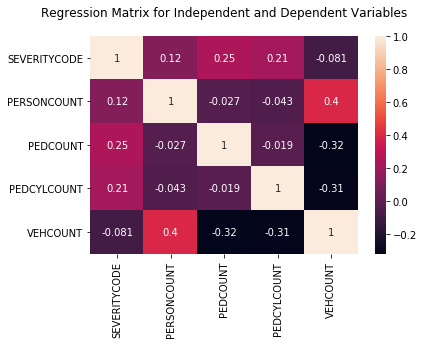

In [9]:
Collisions_corre = Collisions_df[['SEVERITYCODE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']].corr()
sn.heatmap(Collisions_corre, annot=True)
plt.title('Regression Matrix for Independent and Dependent Variables', pad=20)
plt.show()

It could be inferred that Vehcount does not have a significant impact on the dependent variable Severity Code. As the correlation among the other variables tends to be low, one can say variables do not show collinearity issues (are truly independent).

In [10]:
DataAnova = Collisions_df.drop(['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT'],axis=1)

In [11]:
GroupTest1 = DataAnova[['ADDRTYPE','SEVERITYCODE']].groupby(['ADDRTYPE'])
f_val, p_val = stats.f_oneway(GroupTest1.get_group('Intersection')['SEVERITYCODE'],\
                              GroupTest1.get_group('Block')['SEVERITYCODE'],\
                              GroupTest1.get_group('Alley')['SEVERITYCODE'])
print('ANOVA Result for ADDRTYPE. F= ', f_val, 'P= ',p_val)

ANOVA Result for ADDRTYPE. F=  3530.7072025718653 P=  0.0


In [12]:
GroupTest2 = DataAnova[['COLLISIONTYPE','SEVERITYCODE']].groupby(['COLLISIONTYPE'])
f_val, p_val = stats.f_oneway(GroupTest2.get_group('Angles')['SEVERITYCODE'],\
                              GroupTest2.get_group('Sideswipe')['SEVERITYCODE'],\
                              GroupTest2.get_group('Parked Car')['SEVERITYCODE'],\
                              GroupTest2.get_group('Other')['SEVERITYCODE'],\
                              GroupTest2.get_group('Cycles')['SEVERITYCODE'],\
                              GroupTest2.get_group('Head On')['SEVERITYCODE'],\
                              GroupTest2.get_group('Left Turn')['SEVERITYCODE'],\
                              GroupTest2.get_group('Rear Ended')['SEVERITYCODE'],
                              GroupTest2.get_group('Pedestrian')['SEVERITYCODE'],\
                              GroupTest2.get_group('Right Turn')['SEVERITYCODE'])
print('ANOVA Result for COLLISIONTYPE. F= ', f_val, 'P= ',p_val)

ANOVA Result for COLLISIONTYPE. F=  5369.063855492085 P=  0.0


In [13]:
GroupTest3 = DataAnova[['JUNCTIONTYPE','SEVERITYCODE']].groupby(['JUNCTIONTYPE'])
f_val, p_val = stats.f_oneway(GroupTest3.get_group('At Intersection (intersection related)')['SEVERITYCODE'],\
                              GroupTest3.get_group('Mid-Block (not related to intersection)')['SEVERITYCODE'],\
                              GroupTest3.get_group('Driveway Junction')['SEVERITYCODE'],\
                              GroupTest3.get_group('Mid-Block (but intersection related)')['SEVERITYCODE'],\
                              GroupTest3.get_group('At Intersection (but not related to intersection)')['SEVERITYCODE'],\
                              GroupTest3.get_group('Ramp Junction')['SEVERITYCODE'],\
                              GroupTest3.get_group('Unknown')['SEVERITYCODE'])
print('ANOVA Result for JUNCTIONTYPE. F= ', f_val, 'P= ',p_val)                       

ANOVA Result for JUNCTIONTYPE. F=  1403.6201084458635 P=  0.0


In [14]:
GroupTest4 = DataAnova[['WEATHER','SEVERITYCODE']].groupby(['WEATHER'])
f_val,p_val = stats.f_oneway(GroupTest4.get_group('Overcast')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Raining')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Clear')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Unknown')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Other')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Snowing')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Fog/Smog/Smoke')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Sleet/Hail/Freezing Rain')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Blowing Sand/Dirt')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Severe Crosswind')['SEVERITYCODE'],\
                                 GroupTest4.get_group('Partly Cloudy')['SEVERITYCODE'])
print('ANOVA Result for WEATHER. F= ', f_val, 'P= ',p_val) 

ANOVA Result for WEATHER. F=  374.03872251208475 P=  0.0


In [15]:
GroupTest5 = DataAnova[['ROADCOND','SEVERITYCODE']].groupby(['ROADCOND'])
f_val, p_val = stats.f_oneway(GroupTest5.get_group('Wet')['SEVERITYCODE'],\
                              GroupTest5.get_group('Dry')['SEVERITYCODE'],\
                              GroupTest5.get_group('Unknown')['SEVERITYCODE'],\
                              GroupTest5.get_group('Snow/Slush')['SEVERITYCODE'],\
                              GroupTest5.get_group('Ice')['SEVERITYCODE'],\
                              GroupTest5.get_group('Other')['SEVERITYCODE'],\
                              GroupTest5.get_group('Sand/Mud/Dirt')['SEVERITYCODE'],\
                              GroupTest5.get_group('Standing Water')['SEVERITYCODE'],\
                              GroupTest5.get_group('Oil')['SEVERITYCODE'])
print('ANOVA Result for ROADCOND. F= ', f_val, 'P= ',p_val) 

ANOVA Result for ROADCOND. F=  476.04934918417547 P=  0.0


In [16]:
GroupTest6 = DataAnova[['LIGHTCOND','SEVERITYCODE']].groupby(['LIGHTCOND'])
f_val, p_val = stats.f_oneway(GroupTest6.get_group('Daylight')['SEVERITYCODE'],\
                              GroupTest6.get_group('Dark - Street Lights On')['SEVERITYCODE'],\
                              GroupTest6.get_group('Dark - No Street Lights')['SEVERITYCODE'],\
                              GroupTest6.get_group('Unknown')['SEVERITYCODE'],\
                              GroupTest6.get_group('Dusk')['SEVERITYCODE'],\
                              GroupTest6.get_group('Dawn')['SEVERITYCODE'],\
                              GroupTest6.get_group('Dark - Street Lights Off')['SEVERITYCODE'],\
                              GroupTest6.get_group('Other')['SEVERITYCODE'],\
                              GroupTest6.get_group('Dark - Unknown Lighting')['SEVERITYCODE'])
print('ANOVA Result for LIGHTCOND. F= ', f_val, 'P= ',p_val) 

ANOVA Result for LIGHTCOND. F=  463.6488043553831 P=  0.0


In [17]:
GroupTest7 = DataAnova[['SPEEDING','SEVERITYCODE']].groupby(['SPEEDING'])
f_val, p_val = stats.f_oneway(GroupTest7.get_group(0)['SEVERITYCODE'],\
                              GroupTest7.get_group(1)['SEVERITYCODE'])
print('ANOVA Result for SPEEDING. F= ', f_val, 'P= ',p_val) 

ANOVA Result for SPEEDING. F=  223.74371113657483 P=  1.4783415342348403e-50


In [18]:
GroupTest8 = DataAnova[['HITPARKEDCAR','SEVERITYCODE']].groupby(['HITPARKEDCAR'])
f_val, p_val = stats.f_oneway(GroupTest8.get_group(0)['SEVERITYCODE'],\
                              GroupTest8.get_group(1)['SEVERITYCODE'])
print('ANOVA Result for SPEEDING. F= ', f_val, 'P= ',p_val) 

ANOVA Result for SPEEDING. F=  1577.6562406158005 P=  0.0


In [19]:
#The data provided is unbalanced. The number of injuries (56625) is way lower than the number of prop damages (126269)
Collisions_DataModel['SEVERITYCODE'].value_counts()

1    126269
2     56625
Name: SEVERITYCODE, dtype: int64

In [20]:
#Downsampling the number of injuries (Severitycode=1)
df_majority=Collisions_DataModel[Collisions_DataModel['SEVERITYCODE']==1]
df_minority=Collisions_DataModel[Collisions_DataModel['SEVERITYCODE']==2]
df_majority_downsampled = resample(df_majority,replace=False,n_samples=56625,random_state=123)
Collisions_DataModel = pd.concat([df_minority, df_majority_downsampled])
Collisions_DataModel = Collisions_DataModel.reset_index(drop=True)

In [21]:
#Preprocessing
from sklearn import preprocessing
X = np.asarray(Collisions_DataModel.drop(['SEVERITYCODE'],axis=1))
y = np.asarray(Collisions_DataModel['SEVERITYCODE'])
X = preprocessing.StandardScaler().fit(X).transform(X)

In [22]:
#Defining test and train datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (90600, 57) (90600,)
Test set: (22650, 57) (22650,)


In [23]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [24]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
t_start = process_time()
LR = LogisticRegression(C=0.01).fit(X_train,y_train)
yhatLR = LR.predict(X_test)
yhatLRProba = LR.predict_proba(X_test)
t_stop = process_time()
print("Elapsed time for the model:", t_stop-t_start,' seconds') 
print('Accuracy Score of Logistic Regression: ',accuracy_score(y_test,yhatLR))
print('F1 Score of Logistic Regression: ',f1_score(y_test,yhatLR,average='weighted'))
print('Jaccard Score Linear Regression: ', jaccard_score(y_test,yhatLR))
print('Log Loss Linear Regression: ', log_loss(y_test,yhatLRProba))

Elapsed time for the model: 1.390625  seconds
Accuracy Score of Logistic Regression:  0.7007064017660044
F1 Score of Logistic Regression:  0.6977476828195344
Jaccard Score Linear Regression:  0.5004421518054532
Log Loss Linear Regression:  0.5464830678304659


In [25]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
t_start = process_time()
TreeModel = DecisionTreeClassifier(criterion='entropy',max_depth=11)
TreeModel.fit(X_train,y_train)
yhatDT = TreeModel.predict(X_test)
t_stop = process_time()
print("Elapsed time for the model:", t_stop-t_start,' seconds')
print('Accuracy Score of Decision Tree: ',accuracy_score(y_test,yhatDT))
print('F1 Score of Decision Tree: ',f1_score(y_test,yhatDT,average='weighted'))
print('Jaccard Score Decision Tree: ', jaccard_score(y_test,yhatDT))

Elapsed time for the model: 1.0625  seconds
Accuracy Score of Decision Tree:  0.7032671081677704
F1 Score of Decision Tree:  0.6987375036184176
Jaccard Score Decision Tree:  0.49363369245837413


In [26]:
#K Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier
t_start = process_time()
k=11
KNN = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
yhatKNN = KNN.predict(X_test)
t_stop = process_time()
print("Elapsed time for the model:", t_stop-t_start,' seconds')
print('Accuracy Score of KNN: ',accuracy_score(y_test,yhatKNN))
print('F1 Score of KNN: ',f1_score(y_test,yhatKNN,average='weighted'))
print('Jaccard Score of KNN: ', jaccard_score(y_test,yhatKNN))

Elapsed time for the model: 187.8125  seconds
Accuracy Score of KNN:  0.6867549668874172
F1 Score of KNN:  0.6860304396147238
Jaccard Score of KNN:  0.503984899328859


In [27]:
#Support Vector Machine SVM
#from sklearn import svm
#SVM_Model = svm.SVC()
#SVM_Model.fit(X_train,y_train)
#yhatSVM = SVM_Model.predict(X_test)
#print('Accuracy Score of SVM: ',accuracy_score(y_test,yhatSVM))
#print('F1 Score of SVM: ',f1_score(y_test,yhatSVM,average='weighted'))
#print('Jaccard Score of SVM: ', jaccard_score(y_test,yhatSVM))

Computation times for the SVM model are significantly high. No results were obtained.